# Отток клиентов
___
# Customer churn

Из банка начался отток клиентов, имеющий ежемесячный характер. Несмотря на первоначально кажущийся малым объем, в результате данный процесс "ощутим". 

Было принято решение, что дешевле сохранять имеющихся клиентов, нежели тратить средства на привлечение новых.

Необходимо спрогнозировать потенциальную возможность ухода клиента. Данные включают в себя историческую информацию о поведении клиентов.

Нужно построить модель с наибольшим значением **F1-меры**. Целевое значение метрики - 0.59. Для улучшения результатов требуется дополнительное измерение с помощью **AUC-ROC**

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)
___
From the bank began the outflow of customers, which has a monthly character. Despite the initially seemingly small volume, as a result, this process is “felt”.

It was decided that it was cheaper to retain existing customers than to spend money on attracting new ones.

It is necessary to predict the potential for a client to leave. The data includes historical information about customer behavior.

You need to build a model with the largest value of **F1-measures**. The target value of the metric is 0.59. Additional measurement with **AUC-ROC** is required to improve results

Data Source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных
___
## Data preparation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import re
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
df = pd.read_csv('Churn.csv')

In [3]:
df.columns = [re.sub(r"(\w)([A-Z])", r"\1_\2", x, count=5).lower() for x in df.columns]

In [4]:
df = df.drop(['row_number', 'customer_id', 'surname'], axis = 1)

Признаки были удалены по причине того, что являются уникальными для каждого клиента и будут мешать построению функционирующей модели.
___
Features have been removed due to the fact that they are unique for each client and will interfere with the construction of a functioning model.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

Произведено упорядочивание названий колонок. Также был анализ данных на предмет дубликатов и NaN. Были найдены 909 записей NaN  в столбце **tenure**. 

Что с этим делать?

**Tenure** — это сколько лет человек является клиентом банка. Для того, чтобы не терять остальные актуальные данные, следует заполнить эти значения, иначе невозможно будет осуществить обучение. Заполним данные нулями.
___
Column names have been sorted. There was also data analysis for duplicates and NaNs. 909 NaN entries were found in the **tenure** column.

What to do with it?

**Tenure** is how many years a person has been a client of the bank. In order not to lose the rest of the actual data, these values must be filled in, otherwise it will not be possible to carry out training. Fill in the data with zeros.

In [8]:
df['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Для чистоты выборки удалим записи с пропусками.
___
For the purity of the sample, we remove records with gaps.

In [9]:
df = df.dropna() 

In [10]:
data = pd.get_dummies(df, drop_first=True)

In [11]:
data.head(5)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       9091 non-null   int64  
 1   age                9091 non-null   int64  
 2   tenure             9091 non-null   float64
 3   balance            9091 non-null   float64
 4   num_of_products    9091 non-null   int64  
 5   has_cr_card        9091 non-null   int64  
 6   is_active_member   9091 non-null   int64  
 7   estimated_salary   9091 non-null   float64
 8   exited             9091 non-null   int64  
 9   geography_Germany  9091 non-null   uint8  
 10  geography_Spain    9091 non-null   uint8  
 11  gender_Male        9091 non-null   uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 736.9 KB


Поменяем типы данных.
___
Let's change the data types.

In [13]:
data = data.astype({"credit_score":'int32', "age":'int32', "tenure":'int32', "balance":'float32', "num_of_products":'int32', "has_cr_card":'int32', "is_active_member":'int32', "estimated_salary":'float32', "exited":'int32'})

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       9091 non-null   int32  
 1   age                9091 non-null   int32  
 2   tenure             9091 non-null   int32  
 3   balance            9091 non-null   float32
 4   num_of_products    9091 non-null   int32  
 5   has_cr_card        9091 non-null   int32  
 6   is_active_member   9091 non-null   int32  
 7   estimated_salary   9091 non-null   float32
 8   exited             9091 non-null   int32  
 9   geography_Germany  9091 non-null   uint8  
 10  geography_Spain    9091 non-null   uint8  
 11  gender_Male        9091 non-null   uint8  
dtypes: float32(2), int32(7), uint8(3)
memory usage: 417.3 KB


Данные преобразованы, все необходимые значения приведены в числовой вид.
___
The data is converted, all the necessary values are given in numerical form.

In [15]:
target = data['exited']
features = data.drop('exited', axis=1)

In [16]:
features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target, test_size=0.4, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, stratify=target_test, test_size=0.5, random_state=12345)

In [17]:
print(np.shape(features_train))
print(np.shape(target_train))

print(np.shape(features_test))
print(np.shape(target_test))

print(np.shape(features_valid))
print(np.shape(target_valid))

(5454, 11)
(5454,)
(1818, 11)
(1818,)
(1819, 11)
(1819,)


In [18]:
numeric = ['credit_score', 'age', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])   

C:\Users\kiril\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Созданы необходимые выборки.
___
The necessary samples have been created.

## Исследование задачи
___
## Problem research

In [19]:
class_frequency = data['exited'].value_counts(normalize=True)

0    0.796062
1    0.203938
Name: exited, dtype: float64


<AxesSubplot:>

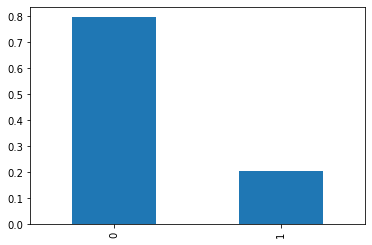

In [20]:
print(class_frequency)
class_frequency.plot(kind='bar')

Объективизирован классовый дисбаланс.
___
Class imbalance has been objectified.

0    0.796113
1    0.203887
Name: exited, dtype: float64


<AxesSubplot:>

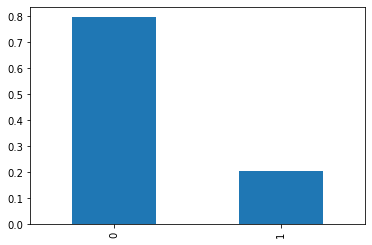

In [21]:
print(target_train.value_counts(normalize=True))
target_train.value_counts(normalize=True).plot(kind='bar')

0    0.79593
1    0.20407
Name: exited, dtype: float64


<AxesSubplot:>

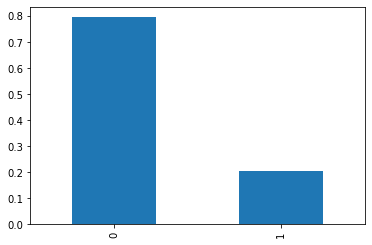

In [22]:
print(target_test.value_counts(normalize=True))
target_test.value_counts(normalize=True).plot(kind='bar')

0    0.796042
1    0.203958
Name: exited, dtype: float64


<AxesSubplot:>

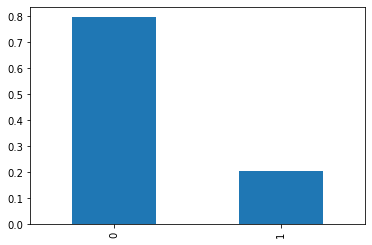

In [23]:
print(target_valid.value_counts(normalize=True))
target_valid.value_counts(normalize=True).plot(kind='bar')

Соотношение классов одинаково во всех выборках.
___
The ratio of classes is the same in all samples.

In [24]:
def roc_auc_graph(model, features, target):
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]

    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid) # < напишите код здесь >

    plt.figure()
    plt.plot(fpr, tpr, linestyle='--')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

Сделаем функцию для визуализации графика **roc_auc**.
___
Let's make a function to visualize the chart **roc_auc**.

In [25]:
def auc_roc(model, features, target):
    probabilities_valid_dt = model.predict_proba(features)
    probabilities_one_valid_dt = probabilities_valid_dt[:, 1]

    return roc_auc_score(target, probabilities_one_valid_dt)

Также создаем функцию для подсчета **roc_auc**.
___
We also create a function to count **roc_auc**.

Возьмем наиболее сильную модель для категориальных целевых признаков и найдем оптимальные гиперпараметры.
___
Let's take the strongest model for categorical target features and find the optimal hyperparameters.

F1: 0.5476603119584055
DecisionTreeClassifier(max_depth=5, random_state=12345)


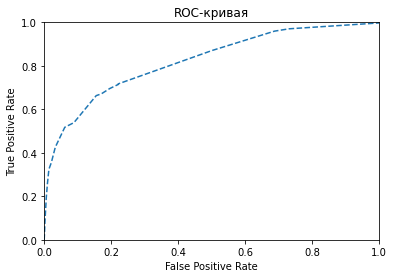

0.8222224911021428

In [26]:
best_model_dt = None
best_result_dt = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result_dt:
        best_model_dt = model 
        best_result_dt = result

print('F1:', best_result_dt)
print(best_model_dt)

roc_auc_graph(best_model_dt, features_valid, target_valid)
roc_auc_score_dt = auc_roc(best_model_dt, features_valid, target_valid)
roc_auc_score_dt

Значения, близкие к целевым, попробуем другие модели.
___
Values close to the target, let's try other models.

F1: 0.35203094777562866
LogisticRegression(max_iter=60, random_state=12345)


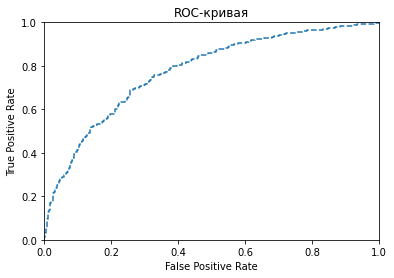

0.7745156438474483

In [27]:
best_model_lr = None
best_result_lr = 0
for iter in range(60, 120):
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iter)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result_lr:
        best_model_lr = model 
        best_result_lr = result 
        
print('F1:', best_result_lr)
print(best_model_lr)

roc_auc_graph(best_model_lr, features_valid, target_valid)
roc_auc_score_lr = auc_roc(best_model_lr, features_valid, target_valid)
roc_auc_score_lr

Слишком малое значение.
___
Too little value.

F1: 0.5612903225806452
RandomForestClassifier(n_estimators=17, random_state=12345)


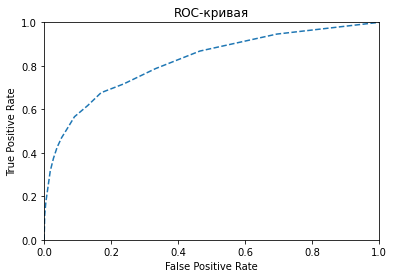

0.8202483954073654

In [28]:
best_model_rf = None
best_result_rf = 0
for est in range(1, 50):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result_rf:
        best_model_rf = model 
        best_result_rf = result 
        
print('F1:', best_result_rf)
print(best_model_rf)

roc_auc_graph(best_model_rf, features_valid, target_valid)
roc_auc_score_rf = auc_roc(best_model_rf, features_valid, target_valid)
roc_auc_score_rf

In [29]:
table = [[best_result_dt, roc_auc_score_dt],
        [best_result_lr, roc_auc_score_lr],
        [best_result_rf, roc_auc_score_rf]]
columns = ['F1', 'ROC-AUC']
index = ['DT', 'LR', 'RF'] 
df = pd.DataFrame(table, index, columns) 
display(df)

,F1,ROC-AUC
DT,0.547660,0.822222
LR,0.352031,0.774516
RF,0.561290,0.820248


Лидирующая модель по показателям ROC-AUC - RF.
___
The leading model in terms of ROC-AUC - RF.

## Борьба с дисбалансом
___
## Fighting imbalance

Попробуем первый способ - взвешивание классов.
___
Let's try the first method - class weighting.

F1: 0.5570971184631803
DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=12345)


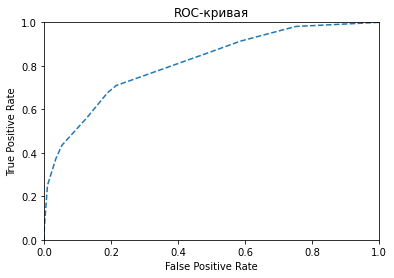

0.8136764530684577

In [30]:
best_model_dt_balance = None
best_result_dt_balance = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') 
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result_dt_balance:
        best_model_dt_balance = model 
        best_result_dt_balance = result

print('F1:', best_result_dt_balance)
print(best_model_dt_balance)

roc_auc_graph(best_model_dt_balance, features_valid, target_valid)
roc_auc_score_dt_balance = auc_roc(best_model_dt_balance, features_valid, target_valid)
roc_auc_score_dt_balance

0.5082125603864733
LogisticRegression(class_weight='balanced', max_iter=60, random_state=12345)


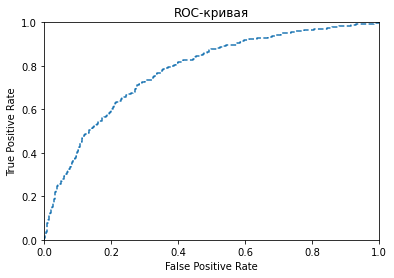

0.7781138776786645

In [31]:
best_model_lr_balance = None
best_result_lr_balance = 0
for iter in range(60, 120):
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iter, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result_lr_balance:
        best_model_lr_balance = model 
        best_result_lr_balance = result 
        

print(best_result_lr_balance)
print(best_model_lr_balance)

roc_auc_graph(best_model_lr_balance, features_valid, target_valid)
roc_auc_score_lr_balance = auc_roc(best_model_lr_balance, features_valid, target_valid)
roc_auc_score_lr_balance

0.5662847790507365
RandomForestClassifier(class_weight='balanced', n_estimators=7,
                       random_state=12345)


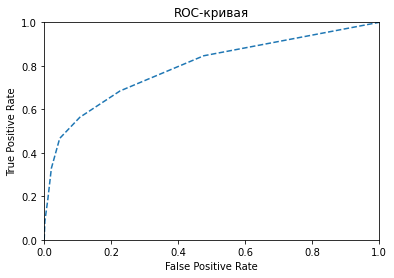

0.794444609909011

In [32]:
best_model_rf_balance = None
best_result_rf_balance = 0
for est in range(1, 50):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result_rf_balance:
        best_model_rf_balance = model 
        best_result_rf_balance = result 
        
print(best_result_rf_balance)
print(best_model_rf_balance)

roc_auc_graph(best_model_rf_balance, features_valid, target_valid)
roc_auc_score_rf_balance = auc_roc(best_model_rf_balance, features_valid, target_valid)
roc_auc_score_rf_balance

Изменения незначительные. Пробуем дальше - апсемплинг. Выровняем соотношение 1:4 до 1:1.
___
The changes are minor. We try further - upsampling. Align the ratio 1:4 to 1:1.

In [33]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

F1: 0.5570971184631803
DecisionTreeClassifier(max_depth=4, random_state=12345)


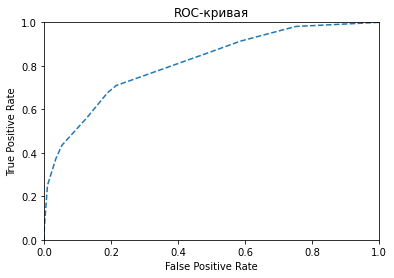

0.8136764530684577

In [34]:
best_model_dt_up = None
best_result_dt_up = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_upsampled, target_upsampled) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result_dt_up:
        best_model_dt_up = model 
        best_result_dt_up = result


print("F1:", best_result_dt_up)
print(best_model_dt_up)

roc_auc_graph(best_model_dt_up, features_valid, target_valid)
roc_auc_score_dt_up = auc_roc(best_model_dt_up, features_valid, target_valid)
roc_auc_score_dt_up

0.5038022813688213
LogisticRegression(max_iter=60, random_state=12345)


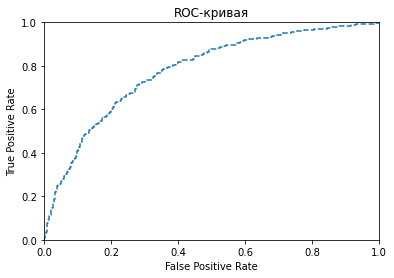

0.7781492457297733

In [35]:
best_model_lr_up = None
best_result_lr_up = 0
for iter in range(60, 120):
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iter)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result_lr_up:
        best_model_lr_up = model 
        best_result_lr_up = result 
        
print(best_result_lr_up)
print(best_model_lr_up)

roc_auc_graph(best_model_lr_up, features_valid, target_valid)
roc_auc_score_lr_up = auc_roc(best_model_lr_up, features_valid, target_valid)
roc_auc_score_lr_up

0.6011904761904762
RandomForestClassifier(n_estimators=29, random_state=12345)


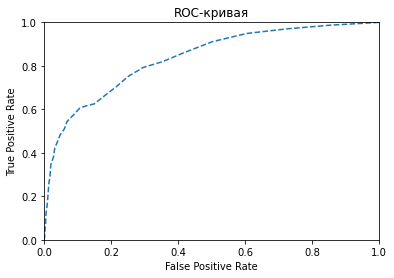

0.835816853062501

In [36]:
best_model_rf_up = None
best_result_rf_up = 0
for est in range(1, 50):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result_rf_up:
        best_model_rf_up = model 
        best_result_rf_up = result 
        
print(best_result_rf_up)
print(best_model_rf_up)

roc_auc_graph(best_model_rf_up, features_valid, target_valid)
roc_auc_score_rf_up = auc_roc(best_model_rf_up, features_valid, target_valid)
roc_auc_score_rf_up

Произошло сравнительное увеличение F1.
___
There was a comparative increase in F1.

С помощью апсемплинга были достигнуты необходимые значения. Попробуем на всякий случай даунсэмплинг.
___
With the help of upsampling, the required values were achieved. Let's try downsampling just in case.

In [37]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)



0.5683060109289617
RandomForestClassifier(n_estimators=20, random_state=12345)


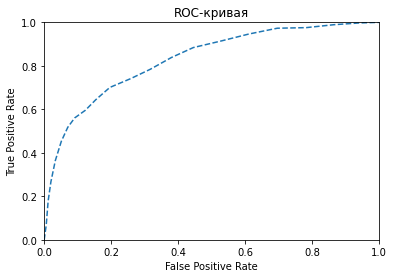

0.830557251567363

In [38]:
best_model_rf_down = None
best_result_rf_down = 0
for est in range(1, 50):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result_rf_down:
        best_model_rf_down = model 
        best_result_rf_down = result 

print(best_result_rf_down)
print(best_model_rf_down)

roc_auc_graph(best_model_rf_down, features_valid, target_valid)
roc_auc_score_rf_down = auc_roc(best_model_rf_down, features_valid, target_valid)
roc_auc_score_rf_down

F1: 0.55779427359491
DecisionTreeClassifier(max_depth=4, random_state=12345)


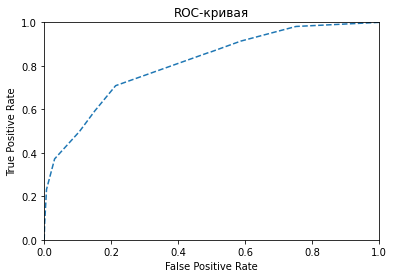

0.8110424639990469

In [39]:
best_model_dt_down = None
best_result_dt_down = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_downsampled, target_downsampled) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result_dt_down:
        best_model_dt_down = model 
        best_result_dt_down = result


print("F1:", best_result_dt_down)
print(best_model_dt_down)

roc_auc_graph(best_model_dt_down, features_valid, target_valid)
roc_auc_score_dt_down = auc_roc(best_model_dt_down, features_valid, target_valid)
roc_auc_score_dt_down

0.5089538171536288
LogisticRegression(max_iter=60, random_state=12345)


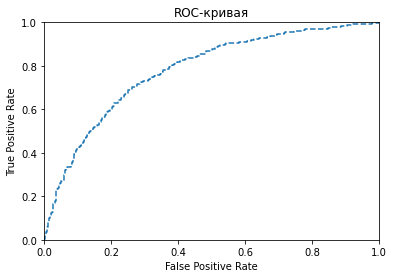

0.7793871275185775

In [40]:
best_model_lr_down = None
best_result_lr_down = 0
for iter in range(60, 120):
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iter)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result_lr_down:
        best_model_lr_down = model 
        best_result_lr_down = result 
        

print(best_result_lr_down)
print(best_model_lr_down)

roc_auc_graph(best_model_lr_down, features_valid, target_valid)
roc_auc_score_lr_down = auc_roc(best_model_lr_down, features_valid, target_valid)
roc_auc_score_lr_down

Очень плохой результат. 
___
Very bad result.

In [41]:
table = [[best_result_dt_balance, best_result_dt_up, best_result_dt_down],
         [roc_auc_score_dt_balance, roc_auc_score_dt_up, roc_auc_score_dt_down],
        [best_result_lr_balance, best_result_lr_up, best_result_lr_down],
         [roc_auc_score_lr_balance, roc_auc_score_lr_up, roc_auc_score_lr_down],
        [best_result_rf_balance, best_result_rf_up, best_result_rf_down],
        [roc_auc_score_rf_balance, roc_auc_score_rf_up, roc_auc_score_rf_down]]
columns = ['class_balance', 'upsampling', 'downsampling']
index = ['DT  f-1', 'DT roc_auc', 'LR  f-1', 'LR  roc_auc', 'RF  f-1', 'RF  roc_auc'] 
df = pd.DataFrame(table, index, columns) 
display(df)

,class_balance,upsampling,downsampling
DT f-1,0.557097,0.557097,0.557794
DT roc_auc,0.813676,0.813676,0.811042
LR f-1,0.508213,0.503802,0.508954
LR roc_auc,0.778114,0.778149,0.779387
RF f-1,0.566285,0.601190,0.568306
RF roc_auc,0.794445,0.835817,0.830557


Самый оптимальный вариант - RF + upsampling, будем использовать его для тестирования модели.
___
The best option is RF + upsampling, we will use it to test the model.

## Тестирование модели

F1: 0.6213872832369942


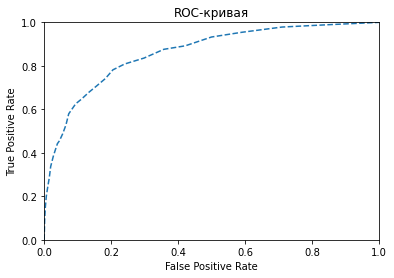

0.8615808895437534

In [42]:
predicted_test_rf_up = best_model_rf_up.predict(features_test)
f1_score_rf_up_test = f1_score(target_test, predicted_test_rf_up)
print("F1:", f1_score_rf_up_test)

roc_auc_graph(best_model_rf_up, features_test, target_test)
roc_auc_score_rf_up_test = auc_roc(best_model_rf_up, features_test, target_test)
roc_auc_score_rf_up_test

Объективно лучшая модель, при тестировании на соответствующей выборке результат превышает ожидания.
___
Objectively the best model, when tested on the appropriate sample, the result exceeds expectations.

Для сравнения проведем тест модели DT + upsampling, как второй по эффективности модели.
___
For comparison, we will test the DT + upsampling model, as the second model in terms of efficiency.

F1: 0.5522682445759368


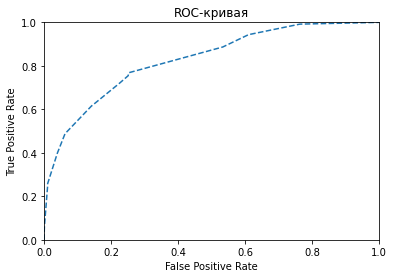

0.8276497335317796

In [43]:
predicted_test_dt_up = best_model_dt_up.predict(features_test)
f1_score_dt_up_test = f1_score(target_test, predicted_test_dt_up)
print("F1:", f1_score_dt_up_test)

roc_auc_graph(best_model_dt_up, features_test, target_test)
roc_auc_score_dt_up_test = auc_roc(best_model_dt_up, features_test, target_test)
roc_auc_score_dt_up_test

Результат недостаточен.

Соответственно самая лучшая модель - сочетание RF и upsampling.
___
The result is not enough.

Accordingly, the best model is a combination of RF and upsampling.